# Similarity calculation

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast
from datasketch import MinHash, MinHashLSH
from tqdm import tqdm
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
import warnings

## Dataset Preprocessing (Paula's part)

Load the dataset that Raquel processed (joining a few different datasets and adding the sentiment analysis)

In [6]:
main_complete = pd.read_csv('data/main_complete.csv')
main_complete_og = main_complete.copy()
main_complete.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,...,music_composer,imdb_rating,imdb_votes,poster_path,Netflix,Amazon,Hulu,Apple,HBO,sentiment
0,2,Ariel,7.1,330.0,Released,1988-10-21,0.0,73.0,0.0,tt0094675,...,NaN,7.4,8735.0,/ojDg0PGvs6R9xYFodRct2kdI6wC.jpg,0.0,1.0,1.0,0.0,0.0,68.24
1,3,Shadows in Paradise,7.3,369.0,Released,1986-10-17,0.0,74.0,0.0,tt0092149,...,NaN,7.5,7484.0,/nj01hspawPof0mJmlgfjuLyJuRN.jpg,0.0,1.0,1.0,0.0,0.0,73.44
2,5,Four Rooms,5.8,2623.0,Released,1995-12-09,4257354.0,98.0,4000000.0,tt0113101,...,Combustible Edison,6.7,112484.0,/75aHn1NOYXh4M7L5shoeQ6NGykP.jpg,0.0,1.0,0.0,1.0,0.0,86.06
3,6,Judgment Night,6.5,331.0,Released,1993-10-15,12136938.0,109.0,21000000.0,tt0107286,...,Alan Silvestri,6.6,19268.0,/3rvvpS9YPM5HB2f4HYiNiJVtdam.jpg,0.0,1.0,0.0,0.0,0.0,79.34
4,8,Life in Loops (A Megacities RMX),7.5,27.0,Released,2006-01-01,0.0,80.0,42000.0,tt0825671,...,NaN,8.2,284.0,/7ln81BRnPR2wqxuITZxEciCe1lc.jpg,0.0,0.0,0.0,0.0,0.0,382.44


To calculate the similarity, we need to do minhashing, that is why, a tokenization is first needed. We wanted to take several features for calculating the jaccard similarity:
- genre
- cast
- crew
- sentiment
- platforms (one-hot encoded)
- crew
- production companies
- production countries
- imbd votes
- imbd rating

To tokenize the features, we created sets for each of them with all the strings of each category inside

### Genres

In [7]:
# check how many movies have no genre
nulls = main_complete['genres'].isnull().sum()
print("This percentage of movies have no genre:", nulls/len(main_complete)*100, "%")

This percentage of movies have no genre: 29.076318106153554 %


In [8]:
# split the genres into a set of genres and remove spaces
main_complete['genres'] = main_complete['genres'].apply(lambda x: set(genre.strip() for genre in x.split(',')) if pd.notnull(x) else set())

We also did a small analysis of the genres to know with what we were working with

There are  19 different genres in the dataset
The genres are: {'Science Fiction', 'Adventure', 'Music', 'History', 'Documentary', 'TV Movie', 'War', 'Mystery', 'Horror', 'Comedy', 'Western', 'Drama', 'Romance', 'Action', 'Crime', 'Thriller', 'Family', 'Fantasy', 'Animation'}


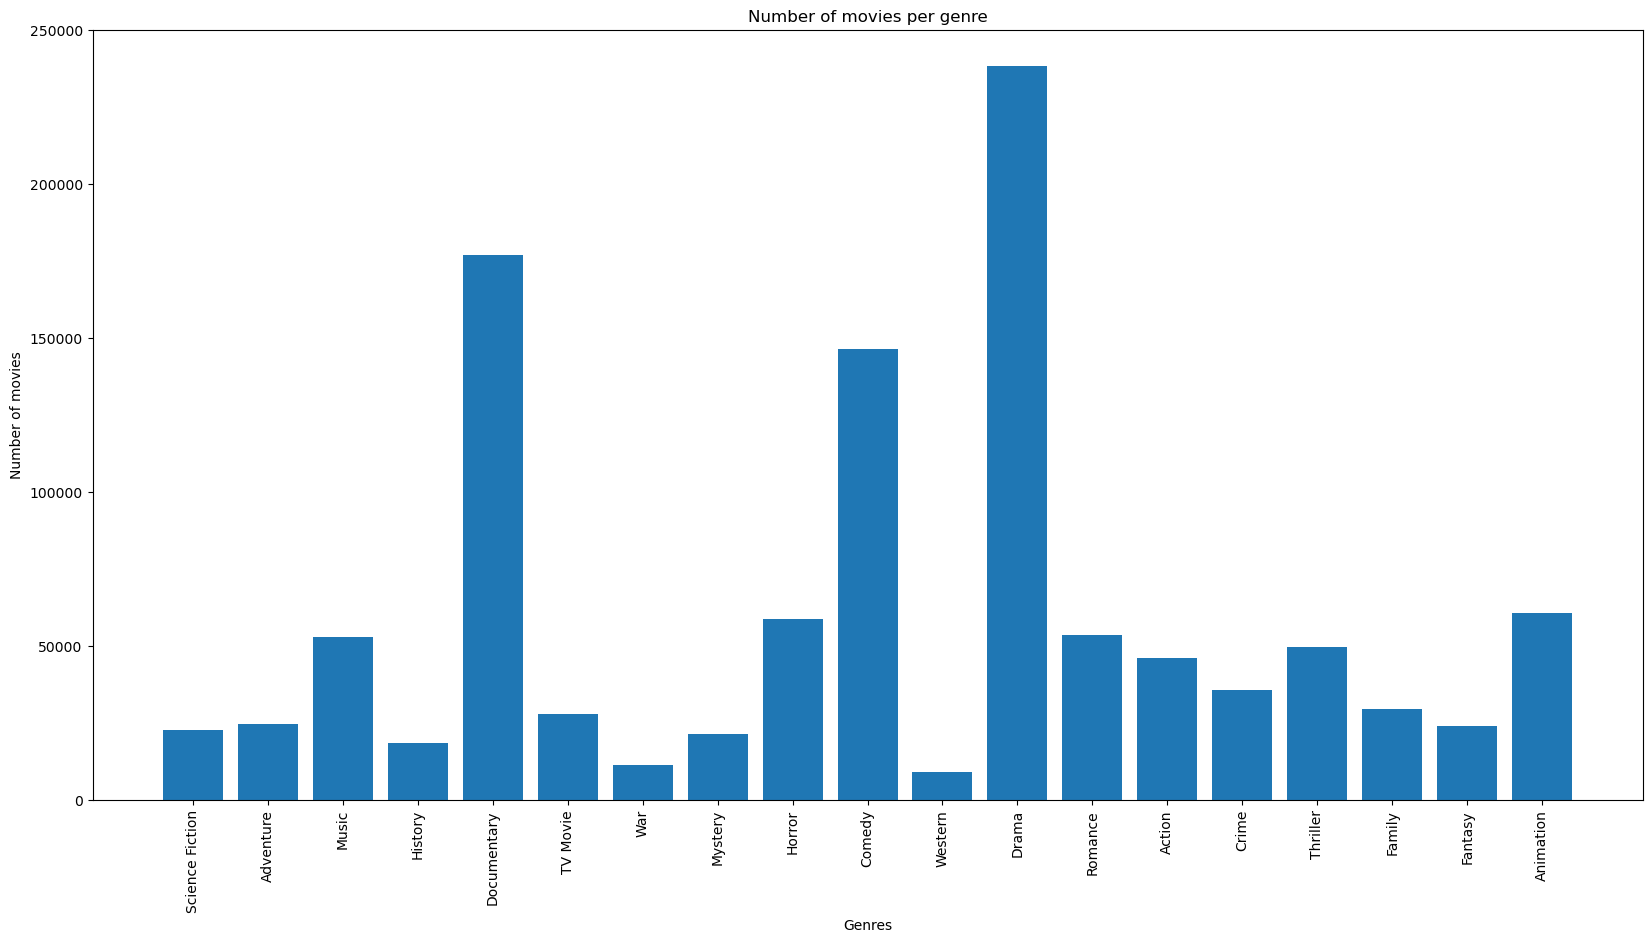

In [9]:
# check how many different genres are taking into account the content of the lists
genres = set()
for list in main_complete['genres']:
    # if list is not NaN
    if list is not np.nan:
        for genre in list:
            # remove the space at the beginning of the string if there is one
            genre = genre.strip()
            genres.add(genre)
print("There are ", len(genres), "different genres in the dataset")
print("The genres are:", genres)

genres_count = {genre: 0 for genre in genres}
for genre_list in main_complete['genres']:
    if genre_list is not np.nan:
        for genre in genre_list:
            genre = genre.strip()
            genres_count[genre] += 1

# histogram
plt.figure(figsize=(20, 10))
plt.bar(genres_count.keys(), genres_count.values())
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Number of movies')
plt.title('Number of movies per genre')
plt.show()

### Cast and crew

We reproduced the same procedure that we did for the genres. In this case, for the crew, we joined the columns of director and producers.

In [10]:
# split the cast into a set of cast and remove spaces
main_complete['cast'] = main_complete['cast'].apply(lambda x: set(actor.strip() for actor in x.split(',')) if pd.notnull(x) else set())

In [11]:
# how many movies have no cast
nulls = main_complete['cast'].apply(lambda x: len(x) == 0).sum()
print("This percentage of movies have no cast:", nulls/len(main_complete)*100, "%")

print(nulls)

This percentage of movies have no cast: 33.29124741666741 %
336188


After doing several tests with the code using different features, we decided to discard the 'cast' one because, since it is long, it has a big weight when calculating the similarities.

In [12]:
# remove the cast column
main_complete = main_complete.drop(columns=['cast'])

In [13]:
# Join the director and producers columns into a single column crew
columns_to_merge = ['director', 'producers']

for column in columns_to_merge:
    main_complete[column] = main_complete[column].apply(lambda x: set(person.strip() for person in x.split(',')) if pd.notnull(x) else set())

main_complete['crew'] = main_complete.apply(lambda row: set.union(row['director'], row['producers']), axis=1)

# Drop the individual columns
main_complete.drop(columns=columns_to_merge, inplace=True)

In [14]:
# how many movies have no crew
nulls = main_complete['crew'].apply(lambda x: len(x) == 0).sum()
print("This percentage of movies have no crew:", nulls/len(main_complete)*100, "%")

This percentage of movies have no crew: 17.2818637426362 %


### Production companies and countries

The same procedure was followed with these two features

In [15]:
# split the production_companies into a set and remove spaces
main_complete['production_companies'] = main_complete['production_companies'].apply(lambda x: set(company.strip() for company in x.split(',')) if pd.notnull(x) else set())
main_complete['production_companies'] = main_complete['production_companies'].apply(lambda x: x - {''})

In [16]:
# percentage of movies with no production companies
nulls = main_complete['production_companies'].apply(lambda x: len(x) == 0).sum()
print("This percentage of movies have no production companies:", nulls/len(main_complete)*100, "%")

This percentage of movies have no production companies: 53.91235632610743 %


In [17]:
main_complete['production_countries'] = main_complete['production_countries'].apply(lambda x: set(country.strip() for country in x.split(',')) if pd.notnull(x) else set())
main_complete['production_countries'] = main_complete['production_countries'].apply(lambda x: x - {''})

In [18]:
# percentage of movies with no production countries
nulls = main_complete['production_countries'].apply(lambda x: len(x) == 0).sum()
print("This percentage of movies have no production countries:", nulls/len(main_complete)*100, "%")

This percentage of movies have no production countries: 39.518774774988884 %


### Sentiment analysis

After calculating the sentiment for each movie, to take it into account for the minhashing, we decided to create three categories depending on the values. This was done due to the fact that dor this method, integers don't work as good as strings (TO REVIEW).

To find the thresholds we ...

In [19]:
sentiment_min = main_complete['sentiment'].min()
sentiment_max = main_complete['sentiment'].max()
sentiment_mean = main_complete['sentiment'].mean()
sentiment_std = main_complete['sentiment'].std()
sentiment_mid = main_complete['sentiment'].median()

print(f"Range of sentiment values: {sentiment_min} to {sentiment_max} with mean {sentiment_mean} and standard deviation {sentiment_std} and median {sentiment_mid}")

Range of sentiment values: 0.0 to 621.52 with mean 109.39746533773106 and standard deviation 83.97651422419462 and median 85.76


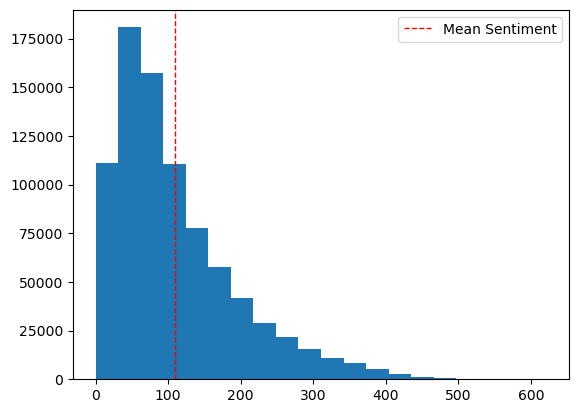

In [20]:
plt.hist(main_complete['sentiment'], bins=20)
plt.axvline(main_complete['sentiment'].mean(), color='r', linestyle='dashed', linewidth=1, label='Mean Sentiment')
plt.legend()
plt.show()

In [21]:
# Define the thresholds for sentiment ranges
low_threshold = sentiment_mean - sentiment_std
high_threshold = sentiment_mean + sentiment_std

# Function to categorize sentiment
def categorize_sentiment(value):
    if value < low_threshold:
        return 'low'
    elif value > high_threshold:
        return 'high'
    else:
        return 'medium'

# Assuming main_complete is already defined and categorize_sentiment is a function
main_complete.loc[:, 'sentiment_category'] = main_complete['sentiment'].apply(categorize_sentiment)

# Display the updated dataframe
main_complete[['title', 'sentiment', 'sentiment_category']].head()

,title,sentiment,sentiment_category
0,Ariel,68.24,medium
1,Shadows in Paradise,73.44,medium
2,Four Rooms,86.06,medium
3,Judgment Night,79.34,medium
4,Life in Loops (A Megacities RMX),382.44,high


### Dataset cleaning

Finally, before doing the minhashing, some movies were deleted from the dataset because they had more than 4 interested features empty and because they were not "Released".

In [22]:
# clean movies with 3 or more interesting columns empty
columns = ['genres', 'crew', 'production_companies', 'production_countries', 'sentiment_category']

initial_count = len(main_complete)

# check each row if they have 3 or more columns from columns with empty sets
main_complete = main_complete[~(main_complete[columns].apply(lambda x: sum(1 for i in x if len(i) == 0) >= 4, axis=1))]
final_count = len(main_complete)

print("Number of movies removed: ", initial_count - final_count, "from a total of ", initial_count)
print("Percentage of movies removed: ", (initial_count - final_count) / initial_count * 100, "%")

Number of movies removed:  94569 from a total of  1009839
Percentage of movies removed:  9.364760125128857 %


In [23]:
# remove movies if the 'status' is not 'Released'
initial_count = len(main_complete)
main_complete = main_complete[main_complete['status'] == 'Released']
final_count = len(main_complete)

print("Number of movies removed: ", initial_count - final_count, "from a total of ", initial_count)
print("Percentage of movies removed: ", (initial_count - final_count) / initial_count * 100, "%")

Number of movies removed:  15995 from a total of  915270
Percentage of movies removed:  1.7475717547827416 %


Finally we saved the processed dataset so that we didn't have to run all the code everytime

## Minhashing

Load the small dataset that is the result of all the previous steps NOT SURE!!!
For some reason, when the dataset is loaded, the tokenization is lost and the similarity is not well calculated.

In [24]:
# prepare data for the minhashing, i just want to keep the columns: title, genre ones, sentiment, cast, crew, production_companies, production_countries and platform ones
data = main_complete[['id', 'title', 'genres', 'sentiment_category', 'Netflix', 'Amazon', 'Hulu', 'Apple', 'HBO', 'crew', 'production_companies', 'production_countries', 'imdb_votes', 'imdb_rating']]

In [25]:
# data = main_complete.copy()

In [26]:
# load the small dataset
# data2 = pd.read_csv('data/small_main_complete.csv')

In [27]:
data.head()

,id,title,genres,sentiment_category,Netflix,Amazon,Hulu,Apple,HBO,crew,production_companies,production_countries,imdb_votes,imdb_rating
0,2,Ariel,"{Romance, Comedy, Crime, Drama}",medium,0.0,1.0,1.0,0.0,0.0,{Aki Kaurismäki},{Villealfa Filmproductions},{Finland},8735.0,7.4
1,3,Shadows in Paradise,"{Romance, Comedy, Drama}",medium,0.0,1.0,1.0,0.0,0.0,"{Aki Kaurismäki, Mika Kaurismäki}",{Villealfa Filmproductions},{Finland},7484.0,7.5
2,5,Four Rooms,{Comedy},medium,0.0,1.0,0.0,1.0,0.0,"{Lawrence Bender, Allison Anders, Quentin Tara...","{A Band Apart, Miramax}",{United States of America},112484.0,6.7
3,6,Judgment Night,"{Thriller, Crime, Action}",medium,0.0,1.0,0.0,0.0,0.0,"{Marilyn Vance, Gene Levy, Stephen Hopkins, Ll...","{JVC, Universal Pictures, Largo Entertainment}",{United States of America},19268.0,6.6
4,8,Life in Loops (A Megacities RMX),{Documentary},high,0.0,0.0,0.0,0.0,0.0,"{Ulrich Gehmacher, Timo Novotny}",{inLoops},{Austria},284.0,8.2


Create the minhashes for each row

In [28]:
# data2.head()

In [29]:
# Function to create a combined MinHash for a movie
def create_combined_minhash(movie, one_hot_features, non_one_hot_features, num_perm=128):
    m = MinHash(num_perm=num_perm)
    
    # Add one-hot encoded features
    for feature in one_hot_features:
        if movie[feature] == 1:
            m.update(feature.encode('utf8'))
    
    # Add non-one-hot encoded features
    for feature in non_one_hot_features:
        for token in movie[feature]:
            m.update(token.encode('utf8'))
    
    return m

In [30]:
# list of one-hot encoded features
one_hot_features = ['Netflix', 'Amazon', 'Hulu', 'Apple', 'HBO']

# list of non-one-hot encoded features
non_one_hot_features = ['genres', 'sentiment_category', 'crew', 'production_companies', 'production_countries']

We create the minhashes taking into account the desired features

In [31]:
minhashes = []
for idx, movie in tqdm(data.iterrows(), total=len(data), desc="Creating MinHashes"):
    minhash = create_combined_minhash(movie, one_hot_features, non_one_hot_features)
    minhashes.append(minhash)

Creating MinHashes: 100%|██████████| 899275/899275 [06:39<00:00, 2249.19it/s]


In [32]:
data['minhash'] = minhashes
data.head()

/var/folders/tf/4m3mvmrd1ddgcyk882fq_c140000gn/T/ipykernel_10936/3287800951.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['minhash'] = minhashes


,id,title,genres,sentiment_category,Netflix,Amazon,Hulu,Apple,HBO,crew,production_companies,production_countries,imdb_votes,imdb_rating,minhash
0,2,Ariel,"{Romance, Comedy, Crime, Drama}",medium,0.0,1.0,1.0,0.0,0.0,{Aki Kaurismäki},{Villealfa Filmproductions},{Finland},8735.0,7.4,<datasketch.minhash.MinHash object at 0x3c467c...
1,3,Shadows in Paradise,"{Romance, Comedy, Drama}",medium,0.0,1.0,1.0,0.0,0.0,"{Aki Kaurismäki, Mika Kaurismäki}",{Villealfa Filmproductions},{Finland},7484.0,7.5,<datasketch.minhash.MinHash object at 0x3c467e...
2,5,Four Rooms,{Comedy},medium,0.0,1.0,0.0,1.0,0.0,"{Lawrence Bender, Allison Anders, Quentin Tara...","{A Band Apart, Miramax}",{United States of America},112484.0,6.7,<datasketch.minhash.MinHash object at 0x3c46b7...
3,6,Judgment Night,"{Thriller, Crime, Action}",medium,0.0,1.0,0.0,0.0,0.0,"{Marilyn Vance, Gene Levy, Stephen Hopkins, Ll...","{JVC, Universal Pictures, Largo Entertainment}",{United States of America},19268.0,6.6,<datasketch.minhash.MinHash object at 0x15118a...
4,8,Life in Loops (A Megacities RMX),{Documentary},high,0.0,0.0,0.0,0.0,0.0,"{Ulrich Gehmacher, Timo Novotny}",{inLoops},{Austria},284.0,8.2,<datasketch.minhash.MinHash object at 0x3c476c...


In order to be computational efficient, a function that interacts with the user is created so that the program calculates the jaccard similarity of all the movies with the one inputed by the user. The result of this function is a list of the 10th more similar movies.

In [33]:
def estimate_jaccard_similarity(data, minhashes, movie_title):
    # Find all movies with the specified title
    matching_movies = data[data['title'] == movie_title]

    if len(matching_movies) > 1:
        print(f"There are multiple movies with the title '{movie_title}'. Please choose one by its id:")
        for idx, row in matching_movies.iterrows():
            print(f"ID: {row['id']}, Crew: {row['crew']}")
        movie_id = int(input("Enter the movie id: "))
        movie_index = data[data['id'] == movie_id].index[0]
        print(f"Selected movie with id '{movie_id}' in position '{movie_index}'")
    elif len(matching_movies) == 1:
        movie_index = data[data['title'] == movie_title].index[0]
        print('movie_index:', movie_index)
        movie_id = data[data['title'] == movie_title]['id'].values[0]
        print(f"movie_id: {movie_id}")
    else:
        print(f"No movies found with the title '{movie_title}'")
        return []

    # Estimate Jaccard similarity with the specified movie
    print(f"Estimated Jaccard Similarity with '{movie_title}':")
    similarity_scores = []

    for i in tqdm(range(len(minhashes)), desc="Calculating Similarities"):
        if i != movie_index:
            similarity = data.iloc[movie_index]['minhash'].jaccard(data.iloc[i]['minhash'])
            similarity_scores.append((data.iloc[i]['title'], similarity, minhashes[i], data.iloc[i]['id']))

    # Sort the similarity scores in descending order
    similarity_scores.sort(key=lambda x: x[1], reverse=True)
    
    return similarity_scores, movie_id

In [34]:
# ask the user to input a movie title
movie_title = input("Enter a movie title: ")

print('The movie title that you entered is:', movie_title)
# estimate the Jaccard similarity with the specified movie
similarity_scores, movie_id = estimate_jaccard_similarity(data, minhashes, movie_title)
print(movie_id)

The movie title that you entered is: Harry Potter and the Philosopher's Stone
movie_index: 541
movie_id: 671
Estimated Jaccard Similarity with 'Harry Potter and the Philosopher's Stone':


Calculating Similarities: 100%|██████████| 899275/899275 [01:07<00:00, 13240.85it/s]


671


In [35]:
similarity_scores[:10]

[('Harry Potter and the Chamber of Secrets',
  0.71875,
  672),
 ('Harry Potter and the Prisoner of Azkaban',
  0.6171875,
  673),
 ("Harry Potter and the Philosopher's Stone (Extended)",
  0.5703125,
  1290195),
 ('Monkeybone', 0.5546875, <datasketch.minhash.MinHash at 0x3d8d90fb0>, 23685),
 ('Night at the Museum',
  0.4921875,
  1593),
 ('The Christmas Chronicles',
  0.484375,
  527435),
 ('Night at the Museum: Kahmunrah Rises Again',
  0.4765625,
  751741),
 ('Percy Jackson & the Olympians: The Lightning Thief',
  0.46875,
  32657),
 ('Percy Jackson: Sea of Monsters',
  0.46875,
  76285),
 ('Valley of the Giants',
  0.46875,
  174767)]

In [36]:
# Function to create a DataFrame with the top N similar movies
def create_top_n_dataframe(similarity_scores, data, movie_id, n=10):
    columns = ['title', 'crew', 'production_companies', 'production_countries', 'sentiment_category', 'Netflix', 'Amazon', 'Hulu', 'Apple', 'HBO']
    top_n_df = pd.DataFrame(columns=columns)
    top_n_list = []
    
    for movie, score, minhash, id in similarity_scores[:n]:
        movie_data = data[data['id'] == id]
        top_n_list.append(movie_data)

    top_n_list.append(data[data['id'] == movie_id])
    top_n_df = pd.concat(top_n_list)
    
    return top_n_df

# Create the DataFrame with the top 10 similar movies
top_10_df = create_top_n_dataframe(similarity_scores, data, movie_id, n=10)
top_10_df

,id,title,genres,sentiment_category,Netflix,Amazon,Hulu,Apple,HBO,crew,production_companies,production_countries,imdb_votes,imdb_rating,minhash
542,672,Harry Potter and the Chamber of Secrets,"{Adventure, Fantasy}",medium,1.0,1.0,1.0,0.0,1.0,"{Chris Columbus, David Barron, Mark Radcliffe,...","{Heyday Films, Warner Bros. Pictures, 1492 Pic...","{United States of America, United Kingdom}",707984.0,7.4,<datasketch.minhash.MinHash object at 0x3c4441...
543,673,Harry Potter and the Prisoner of Azkaban,"{Adventure, Fantasy}",medium,1.0,1.0,1.0,0.0,1.0,"{Callum McDougall, Mark Radcliffe, Tanya Segha...","{Warner Bros. Pictures, Heyday Films, P of A P...","{United States of America, United Kingdom}",708032.0,7.9,<datasketch.minhash.MinHash object at 0x3c4440...
933332,1290195,Harry Potter and the Philosopher's Stone (Exte...,"{Adventure, Fantasy}",medium,0.0,0.0,0.0,0.0,0.0,{},"{Heydey Films, Warner Bros. Pictures, 1492 Pic...","{United States of America, United Kingdom}",NaN,NaN,<datasketch.minhash.MinHash object at 0x4b63ef...
14003,23685,Monkeybone,"{Adventure, Fantasy, Animation, Science Fictio...",medium,0.0,0.0,0.0,0.0,0.0,"{Sam Hamm, Chris Columbus, Henry Selick, Mark ...","{20th Century Fox, 1492 Pictures, Twitching Im...",{United States of America},19448.0,4.8,<datasketch.minhash.MinHash object at 0x3d8d90...
1042,1593,Night at the Museum,"{Adventure, Family, Fantasy, Action, Comedy}",medium,0.0,0.0,1.0,0.0,0.0,"{Chris Columbus, Mark Radcliffe, Ira Shuman, S...","{20th Century Fox, Sun Canada Productions, Ing...","{United States of America, United Kingdom}",385061.0,6.5,<datasketch.minhash.MinHash object at 0x3c41ee...
367640,527435,The Christmas Chronicles,"{Adventure, Comedy, Fantasy, Family}",medium,1.0,0.0,0.0,0.0,0.0,"{Chris Columbus, Adam Kolbrenner, Mark Radclif...","{Madhouse Entertainment, Ocean Blue Entertainm...",{United States of America},84388.0,7.0,<datasketch.minhash.MinHash object at 0x445adc...
535608,751741,Night at the Museum: Kahmunrah Rises Again,"{Animation, Comedy, Fantasy, Family}",medium,0.0,0.0,0.0,0.0,0.0,"{Chris Columbus, Matt Danner, Mark Radcliffe, ...","{21 Laps Entertainment, 1492 Pictures, Walt Di...",{United States of America},2685.0,5.0,<datasketch.minhash.MinHash object at 0x468298...
20528,32657,Percy Jackson & the Olympians: The Lightning T...,"{Adventure, Fantasy, Family}",medium,1.0,1.0,0.0,0.0,0.0,"{Guy Oseary, Karen Rosenfelt, Mark Radcliffe, ...","{Dune Entertainment, Sunswept Entertainment, 1...",{United States of America},206173.0,5.9,<datasketch.minhash.MinHash object at 0x3efa49...
53668,76285,Percy Jackson: Sea of Monsters,"{Adventure, Fantasy, Family}",medium,1.0,1.0,0.0,0.0,0.0,"{Guy Oseary, Karen Rosenfelt, Mark Radcliffe, ...","{Sunswept Entertainment, TSG Entertainment, Fo...",{United States of America},128607.0,5.7,<datasketch.minhash.MinHash object at 0x3f5c9f...
104944,174767,Valley of the Giants,{Adventure},medium,0.0,0.0,0.0,0.0,0.0,{William Keighley},{Warner Bros. Pictures},{United States of America},293.0,6.2,<datasketch.minhash.MinHash object at 0x40f331...


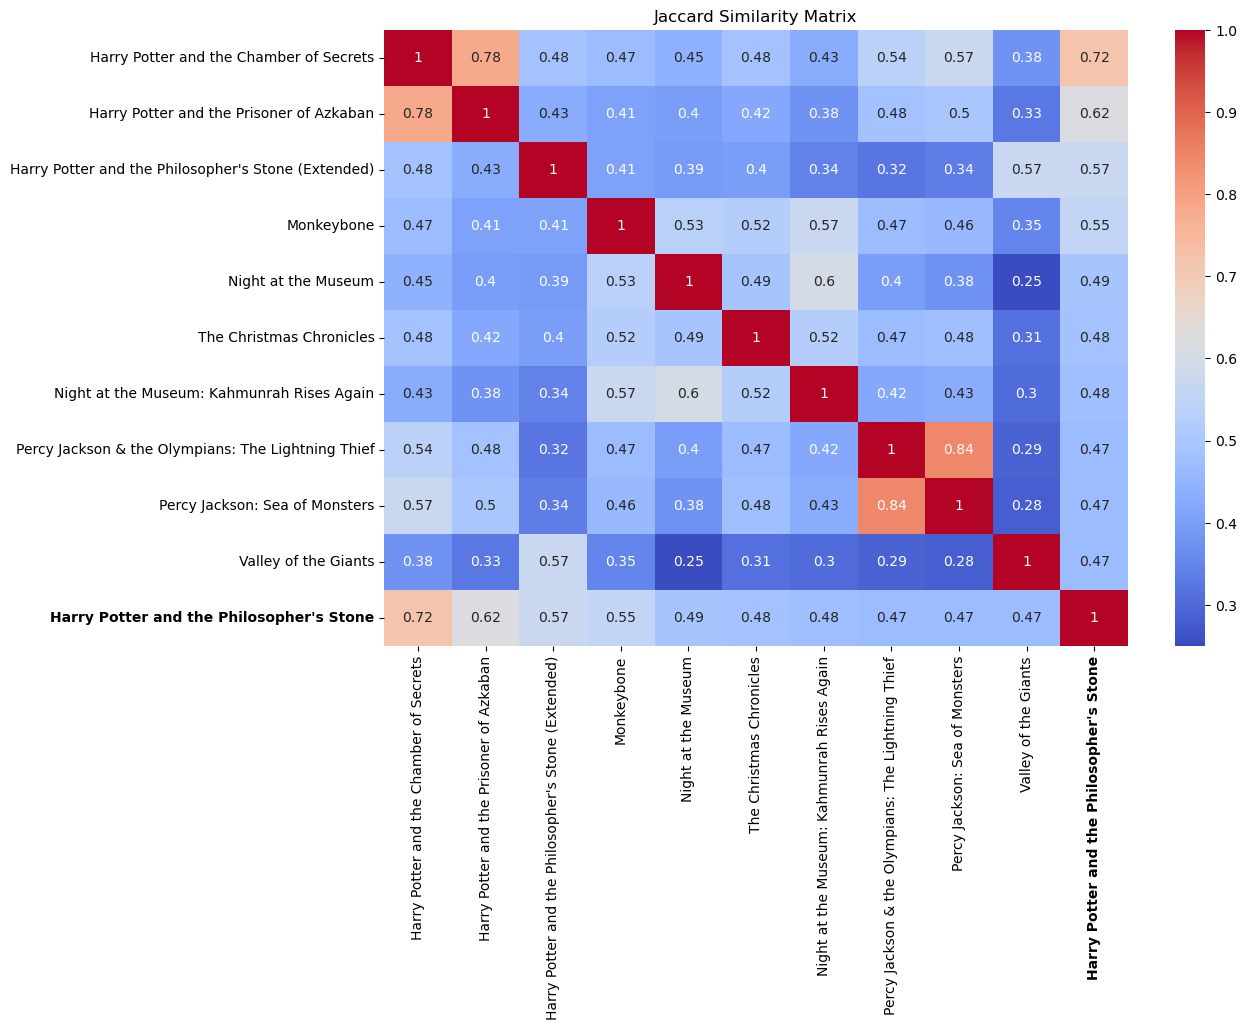

In [37]:
import seaborn as sns

# Function to calculate the Jaccard similarity matrix
def calculate_jaccard_similarity_matrix(top_10_df):
    jaccard_similarity_matrix = np.zeros((len(top_10_df), len(top_10_df)))
    for i in range(len(top_10_df)):
        for j in range(len(top_10_df)):
            jaccard_similarity = top_10_df.iloc[i]['minhash'].jaccard(top_10_df.iloc[j]['minhash'])
            jaccard_similarity_matrix[i][j] = jaccard_similarity
    return jaccard_similarity_matrix

# Calculate the Jaccard similarity matrix
jaccard_similarity_matrix = calculate_jaccard_similarity_matrix(top_10_df)

# Create a heatmap with movie titles
plt.figure(figsize=(12, 8))
sns.heatmap(jaccard_similarity_matrix, annot=True, cmap='coolwarm', xticklabels=top_10_df['title'], yticklabels=top_10_df['title'])
plt.title('Jaccard Similarity Matrix')
# plt.xlabel('Movies')
# plt.ylabel('Movies')
# Get the current axes
ax = plt.gca()

# Get the x and y labels
xticklabels = ax.get_xticklabels()
yticklabels = ax.get_yticklabels()

# Make the "Harry Potter and the Philosopher's Stone" label bold on both x and y axis
for i, label in enumerate(xticklabels):
    if label.get_text() == movie_title:
        label.set_fontweight('bold')

for i, label in enumerate(yticklabels):
    if label.get_text() == movie_title:
        label.set_fontweight('bold')

# Apply the updated labels
ax.set_xticklabels(xticklabels)
ax.set_yticklabels(yticklabels)

plt.show()


# Clustering

In [38]:
# convert to 0 all nan values in the column imdb_votes
main_complete['imdb_votes'] = main_complete['imdb_votes'].fillna(0)

# convert to 0 all nan values in the column imdb_rating
main_complete['imdb_rating'] = main_complete['imdb_rating'].fillna(0)

### K-means Clustering

In [65]:
warnings.filterwarnings("ignore", category=UserWarning, module='pandas')

# Select the features ('imdb_rating' and 'imdb_votes')
features = main_complete[['imdb_rating', 'imdb_votes']]

# Separate "Unseen Titles" (movies with 0 votes and 0 ratings)
unseen_titles = main_complete[(main_complete['imdb_rating'] == 0) & (main_complete['imdb_votes'] == 0)]
cluster_data = main_complete[(main_complete['imdb_rating'] != 0) | (main_complete['imdb_votes'] != 0)]

# Standardize the features for clustering
features_to_cluster = cluster_data[['imdb_rating', 'imdb_votes']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_to_cluster)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_data['cluster'] = kmeans.fit_predict(scaled_features)

# Compute Davies-Bouldin Index
dbi_score = davies_bouldin_score(scaled_features, cluster_data['cluster'])
print(f"Davies-Bouldin Index: {dbi_score}")

# Assign "Unseen Titles" a new cluster label
unseen_titles['cluster'] = 3  # Assign a distinct cluster label for unseen titles

# Combine all data
result_data = pd.concat([cluster_data, unseen_titles], axis=0)

# Save results to CSV with only title and cluster
result_data[['title', 'cluster', 'Netflix',	'Amazon', 'Hulu', 'Apple', 'HBO']].to_csv('movies_with_clusters.csv', index=False)
print("CSV with movie titles and clustering results saved successfully.")


/var/folders/tf/4m3mvmrd1ddgcyk882fq_c140000gn/T/ipykernel_10936/1612721223.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data['cluster'] = kmeans.fit_predict(scaled_features)
/var/folders/tf/4m3mvmrd1ddgcyk882fq_c140000gn/T/ipykernel_10936/1612721223.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unseen_titles['cluster'] = 3  # Assign a distinct cluster label for unseen titles


Davies-Bouldin Index: 0.5856433497128725
CSV with movie titles and clustering results saved successfully.


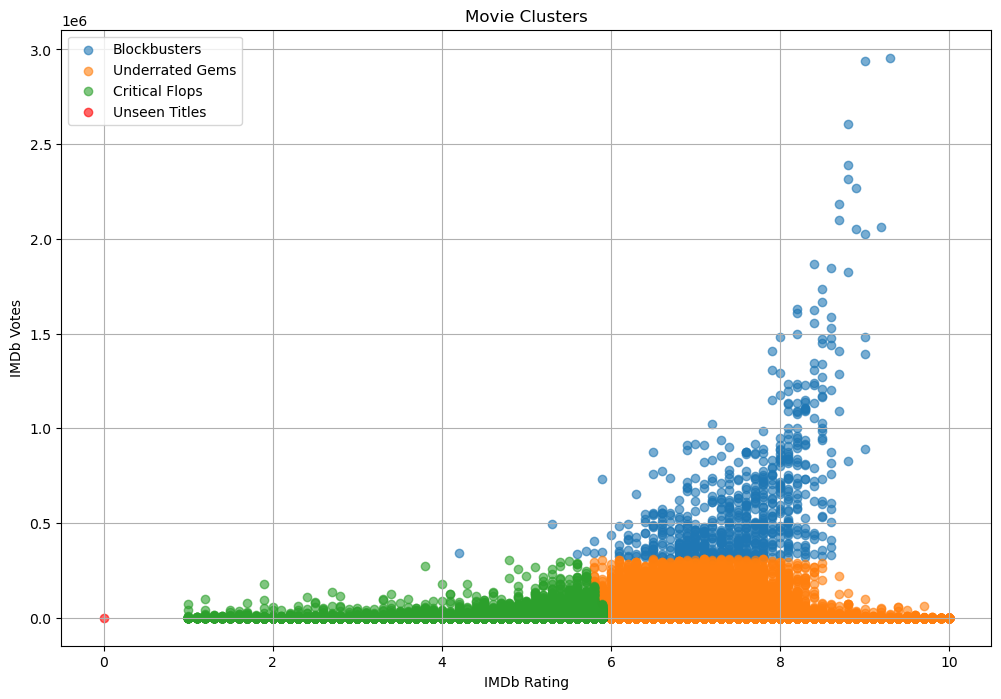

In [ ]:
# Define cluster titles
cluster_titles = {
    2: 'Blockbusters',
    0: 'Underrated Gems',
    1: 'Critical Flops',
    3: 'Unseen Titles'
}

clustered_movies = cluster_data.copy()  # Movies used in k-means clustering
unseen_movies = unseen_titles.copy()    # Movies with 0 votes and 0 ratings

# Plot clustered movies
plt.figure(figsize=(12, 8))

# Plot each cluster
for cluster, title in cluster_titles.items():
    if cluster != 3:
        cluster_subset = clustered_movies[clustered_movies['cluster'] == cluster]
        plt.scatter(cluster_subset['imdb_rating'], cluster_subset['imdb_votes'], 
                    label=title, alpha=0.6)

# Plot "Unseen Titles"
plt.scatter(0, 0, c='red', label=cluster_titles[3],  alpha=0.6)


plt.title('Movie Clusters')
plt.xlabel('IMDb Rating')
plt.ylabel('IMDb Votes')
plt.legend(loc='upper left', frameon=True)
plt.grid(True)


plt.show()

### DBSCAN

Davies-Bouldin Index: 1.2811780537784034


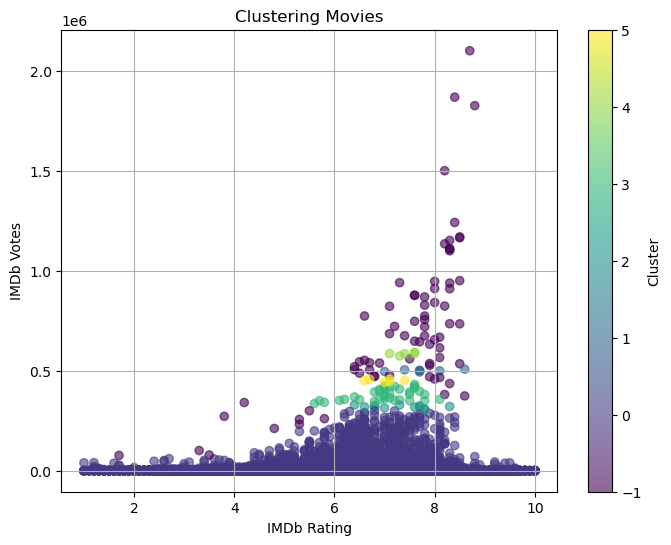

In [ ]:
# Select the features ('imdb_rating' and 'imdb_votes')
features = main_complete[['imdb_rating', 'imdb_votes']]

# Separate "Unseen Titles" (movies with 0 votes and 0 ratings)
unseen_titles = main_complete[(main_complete['imdb_rating'] == 0) & (main_complete['imdb_votes'] == 0)]
cluster_data = main_complete[(main_complete['imdb_rating'] != 0) | (main_complete['imdb_votes'] != 0)]

# Sample the data
sample_data = cluster_data.sample(frac=0.2, random_state=42)

# Standardize the features for clustering
features_to_cluster = sample_data[['imdb_rating', 'imdb_votes']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_to_cluster)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5) 
sample_data['cluster'] = dbscan.fit_predict(scaled_features)

# Compute Davies-Bouldin Index
dbi_score = davies_bouldin_score(scaled_features, sample_data['cluster'])
print(f"Davies-Bouldin Index: {dbi_score}")

# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(sample_data['imdb_rating'], sample_data['imdb_votes'], 
                       c=sample_data['cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title('Clustering Movies')
plt.xlabel('IMDb Rating')
plt.ylabel('IMDb Votes')
plt.grid(True)
plt.show()

### Heriarchical Clustering

Davies-Bouldin Index: 0.6422698545717759


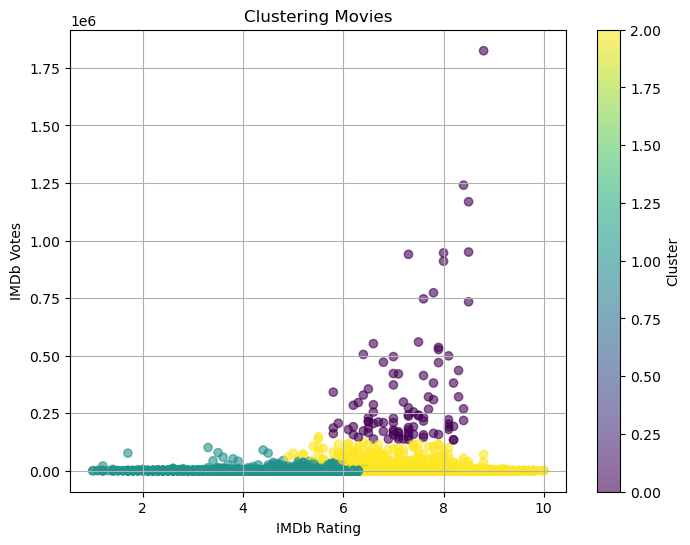

In [79]:
# Select the features ('imdb_rating' and 'imdb_votes')
features = main_complete[['imdb_rating', 'imdb_votes']]

# Separate "Unseen Titles" (movies with 0 votes and 0 ratings)
unseen_titles = main_complete[(main_complete['imdb_rating'] == 0) & (main_complete['imdb_votes'] == 0)]
cluster_data = main_complete[(main_complete['imdb_rating'] != 0) | (main_complete['imdb_votes'] != 0)]

# Sample the data
sample_data = cluster_data.sample(frac=0.05, random_state=42)

# Standardize the features for clustering
features_to_cluster = sample_data[['imdb_rating', 'imdb_votes']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_to_cluster)

# Apply Hierarchical Clustering using Agglomerative Clustering
agg_clust = AgglomerativeClustering(n_clusters=3) 
sample_data['cluster'] = agg_clust.fit_predict(scaled_features)

# Compute Davies-Bouldin Index
dbi_score = davies_bouldin_score(scaled_features, sample_data['cluster'])
print(f"Davies-Bouldin Index: {dbi_score}")

# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(sample_data['imdb_rating'], sample_data['imdb_votes'], 
                       c=sample_data['cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title('Clustering Movies')
plt.xlabel('IMDb Rating')
plt.ylabel('IMDb Votes')
plt.grid(True)
plt.show()

# Find suggested movies in clusters

In [66]:
movies_with_clusters = pd.read_csv('movies_with_clusters.csv')
print(movies_with_clusters.head())

                              title  cluster  Netflix  Amazon  Hulu  Apple  \
0                             Ariel        0      0.0     1.0   1.0    0.0   
1               Shadows in Paradise        0      0.0     1.0   1.0    0.0   
2                        Four Rooms        0      0.0     1.0   0.0    1.0   
3                    Judgment Night        0      0.0     1.0   0.0    0.0   
4  Life in Loops (A Megacities RMX)        0      0.0     0.0   0.0    0.0   

   HBO  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0  


In [75]:
movies_with_clusters = pd.read_csv('movies_with_clusters.csv')

movie_list = top_10_df['title'].tolist()

filtered_movies = movies_with_clusters[movies_with_clusters['title'].isin(movie_list)]

cluster_labels = {
    2: 'Blockbusters',
    0: 'Underrated Gems',
    1: 'Critical Flops',
    3: 'Unseen Titles'
}

filtered_movies = filtered_movies.copy()

filtered_movies['cluster'] = filtered_movies['cluster'].map(cluster_labels)

print(filtered_movies[['title', 'cluster']])



                                                    title          cluster
539              Harry Potter and the Philosopher's Stone     Blockbusters
540               Harry Potter and the Chamber of Secrets     Blockbusters
541              Harry Potter and the Prisoner of Azkaban     Blockbusters
1039                                  Night at the Museum     Blockbusters
13616                                          Monkeybone   Critical Flops
19727   Percy Jackson & the Olympians: The Lightning T...  Underrated Gems
49212                      Percy Jackson: Sea of Monsters   Critical Flops
92751                                Valley of the Giants  Underrated Gems
260237                           The Christmas Chronicles  Underrated Gems
328213         Night at the Museum: Kahmunrah Rises Again   Critical Flops
851566  Harry Potter and the Philosopher's Stone (Exte...    Unseen Titles


In [77]:
# Load the data
movies_with_clusters = pd.read_csv('movies_with_clusters.csv')

# Get the list of movie titles
movie_list = top_10_df['title'].tolist()

# Filter movies based on the list
filtered_movies = movies_with_clusters[movies_with_clusters['title'].isin(movie_list)]

# Debug: Check if filtered_movies is empty
if filtered_movies.empty:
    print("No movies found in the filtered list. Please check the movie titles or data consistency.")
else:
    # Define cluster labels
    cluster_labels = {
        2: 'Blockbusters',
        0: 'Underrated Gems',
        1: 'Critical Flops',
        3: 'Unseen Titles'
    }

    # Map the cluster numbers to descriptive labels
    filtered_movies = filtered_movies.copy()
    filtered_movies['cluster'] = filtered_movies['cluster'].map(cluster_labels)

    # Define platform columns
    platform_columns = ['Netflix', 'Amazon', 'Hulu', 'Apple', 'HBO']

    # Create 'In Platforms' column listing all platforms where the movie is available
    filtered_movies['In Platforms'] = filtered_movies[platform_columns] \
        .apply(lambda row: ', '.join([platform for platform in platform_columns if row[platform] == 1.0]) 
               if any(row[platform] == 1.0 for platform in platform_columns) else 'Not available', axis=1)

    # Separate and print movies by clusters
    for cluster_name in cluster_labels.values():
        print(f"Movies in {cluster_name}:")
        cluster_movies = filtered_movies[filtered_movies['cluster'] == cluster_name]
        if cluster_movies.empty:
            print("No movies in this cluster.")
        else:
            print(cluster_movies[['title', 'In Platforms']])

Movies in Blockbusters:
                                         title                In Platforms
539   Harry Potter and the Philosopher's Stone               Not available
540    Harry Potter and the Chamber of Secrets  Netflix, Amazon, Hulu, HBO
541   Harry Potter and the Prisoner of Azkaban  Netflix, Amazon, Hulu, HBO
1039                       Night at the Museum                        Hulu
Movies in Underrated Gems:
                                                    title     In Platforms
19727   Percy Jackson & the Olympians: The Lightning T...  Netflix, Amazon
92751                                Valley of the Giants    Not available
260237                           The Christmas Chronicles          Netflix
Movies in Critical Flops:
                                             title     In Platforms
13616                                   Monkeybone    Not available
49212               Percy Jackson: Sea of Monsters  Netflix, Amazon
328213  Night at the Museum: Kahmunrah Rises

In [78]:
from tabulate import tabulate

# Separate and print movies by clusters
for cluster_name in cluster_labels.values():
    print(f"\nMovies in {cluster_name}:\n")
    cluster_movies = filtered_movies[filtered_movies['cluster'] == cluster_name]
    if cluster_movies.empty:
        print("No movies in this cluster.")
    else:
        # Format the DataFrame into a table using tabulate
        print(tabulate(cluster_movies[['title', 'In Platforms']], headers='keys', tablefmt='pretty'))


Movies in Blockbusters:

+------+------------------------------------------+----------------------------+
|      |                  title                   |        In Platforms        |
+------+------------------------------------------+----------------------------+
| 539  | Harry Potter and the Philosopher's Stone |       Not available        |
| 540  | Harry Potter and the Chamber of Secrets  | Netflix, Amazon, Hulu, HBO |
| 541  | Harry Potter and the Prisoner of Azkaban | Netflix, Amazon, Hulu, HBO |
| 1039 |           Night at the Museum            |            Hulu            |
+------+------------------------------------------+----------------------------+

Movies in Underrated Gems:

+--------+----------------------------------------------------+-----------------+
|        |                       title                        |  In Platforms   |
+--------+----------------------------------------------------+-----------------+
| 19727  | Percy Jackson & the Olympians: The Light